Based on: https://strike.scec.org/cvws/seas/download/SEAS_BP1_QD.pdf

Goals:
- make another version that also includes a viscoelastic layer!

Possible issues:

Fault tips: 
- Identify or specify singularities and then make sure that the QBX and quadrature account for the singularities. This would be helpful for avoiding the need to have the sigmoid transition.
- *Would it be useful to use an interpolation that includes the end points so that I can easily make sure that slip goes to zero at a fault tip?*

Initial conditions:
- Is the creep initial condition somehow wrong?
- Would a slip deficit formulation be easier to get right?
- What about just using far-field plate rate BCs?
- *The pre-stress formulation from the SEAS document!*

problem: how do I impose a backslip forcing? ultimately, this is physically unrealistic but I need to do it anyway. 
- look at how the scec seas project does this?
- use some tapering function?
- have a basal panel that just has a linear imposed backslip.

In [1]:
from config import setup, import_and_display_fnc

setup()

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix2,
    single_layer_matrix,
    double_layer_matrix,
    adjoint_double_layer_matrix,
    hypersingular_matrix,
    stage1_refine,
    qbx_panel_setup,
    stage2_refine,
    pts_grid,
)

In [59]:
import quadpy

def clencurt(n1):
    """Computes the Clenshaw Curtis quadrature nodes and weights"""
    C = quadpy.c1.clenshaw_curtis(n1)
    return (C.points, C.weights)

In [153]:
surf_half_L = 100000
fault_bottom = 40000
max_panel_length = 600
shear_modulus = 3.2e10

qx, qw = gauss_rule(12)
t = sp.var("t")

control_points = [
    (0, -fault_bottom / 2, fault_bottom / 2, max_panel_length),
]
fault, free = stage1_refine(
    [
        (t, t * 0, fault_bottom * (t + 1) * -0.5),  # fault
        (t, -t * surf_half_L, 0 * t),  # free surface
    ],
    (qx, qw),
    control_points=control_points,
)

fault_expansions, free_expansions = qbx_panel_setup(
    [fault, free], directions=[0, 1], singularities=np.array([[0, -fault_bottom]])
)

In [154]:
fault.n_panels, fault.n_pts

(128, 1536)

In [155]:
fault_expansions.pts[-5:]

array([[ 2.08568573e+01, -3.99012237e+04],
       [ 1.56426430e+01, -3.99355184e+04],
       [ 8.79898667e+00, -3.99640473e+04],
       [ 3.71207250e+00, -3.99850183e+04],
       [ 6.60669154e-01, -3.99971188e+04]])

In [195]:
def build_op(p, kappa):
    free_disp_to_free_disp = qbx_matrix2(
        double_layer_matrix, free, free.pts, free_expansions, p=p, kappa=kappa
    )[:, 0, :]
    fault_slip_to_free_disp = qbx_matrix2(
        double_layer_matrix, fault, free.pts, free_expansions, p=p, kappa=kappa
    )[:, 0, :]

    free_disp_solve_mat = np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
    free_disp_solve_mat_inv = np.linalg.inv(free_disp_solve_mat)

    fault_slip_to_fault_stress = shear_modulus * qbx_matrix2(
        hypersingular_matrix, fault, fault.pts, fault_expansions, p=p, kappa=kappa
    )
    free_disp_to_fault_stress = shear_modulus * qbx_matrix2(
        hypersingular_matrix, free, fault.pts, fault_expansions, p=p, kappa=kappa
    )

    fault_slip_to_fault_traction = np.sum(
        fault_slip_to_fault_stress * fault.normals[:, :, None], axis=1
    )
    free_disp_to_fault_traction = np.sum(
        free_disp_to_fault_stress * fault.normals[:, :, None], axis=1
    )

    A = fault_slip_to_fault_traction
    B = free_disp_to_fault_traction
    C = fault_slip_to_free_disp
    Dinv = free_disp_solve_mat_inv
    total_fault_slip_to_fault_traction = A - B.dot(Dinv.dot(C))
    return total_fault_slip_to_fault_traction

In [127]:
# Ms = []
# for p in range(5, 20, 2):
#     Ms.append(build_op(p))

# slip = np.ones_like(fault.pts[:,1])# / fault_bottom
# v1 = Ms[-2].dot(slip)
# v2 = Ms[-1].dot(slip)
# plt.plot(np.log10(np.abs(v1)))
# plt.plot(np.log10(np.abs(v2)))
# plt.show()
# plt.plot(np.log10(np.abs(v1 - v2)))
# plt.show()
# plt.plot(np.log10(np.abs((v1 - v2) / 1e6)))
# plt.show()

In [157]:
total_fault_slip_to_fault_traction = build_op(10)

In [196]:
total_fault_slip_to_fault_traction2 = build_op(12, 5)

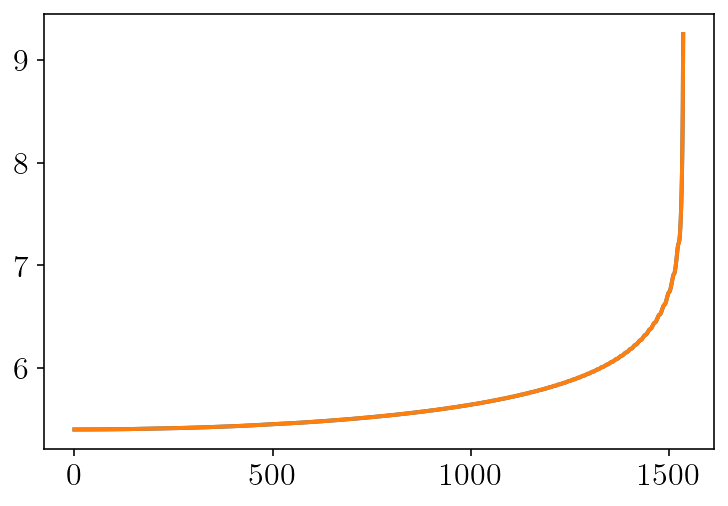

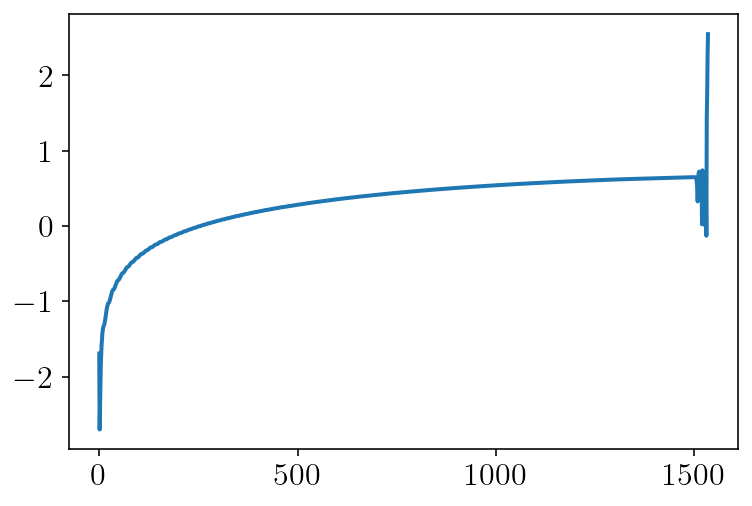

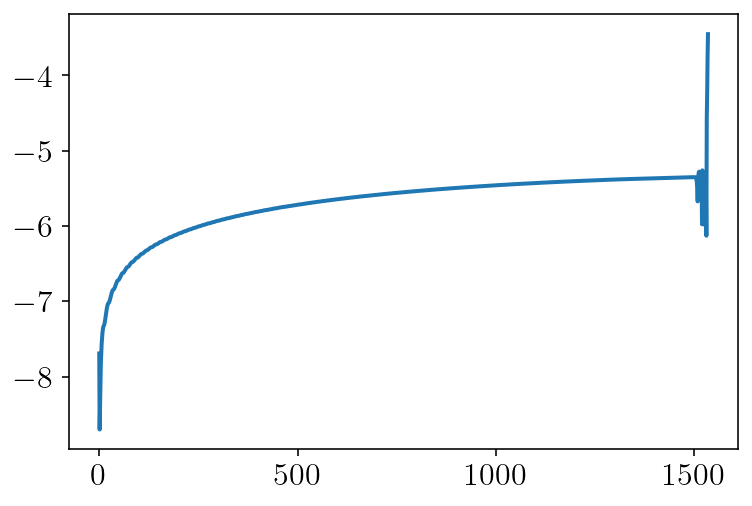

In [197]:
slip = np.ones_like(fault.pts[:,1])# / fault_bottom
v1 = total_fault_slip_to_fault_traction.dot(slip)
v2 = total_fault_slip_to_fault_traction2.dot(slip)
plt.plot(np.log10(np.abs(v1)))
plt.plot(np.log10(np.abs(v2)))
plt.show()
plt.plot(np.log10(np.abs(v1 - v2)))
plt.show()
plt.plot(np.log10(np.abs((v1 - v2) / 1e6)))
plt.show()

## Rate and state friction

In [158]:
from dataclasses import dataclass

In [159]:
@dataclass
class FrictionParams:
    a: np.ndarray
    b: float
    V0: float
    Dc: float
    f0: float

In [160]:
siay = 31556952
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n = 50e6  # Normal stress (Pa)

a0 = 0.01
amax = 0.025
fy = fault.pts[:, 1]
H = 15000
h = 3000
a = np.where(
    fy > -H, a0, np.where(fy > -(H + h), a0 + (amax - a0) * (fy + H) / -h, amax)
)

fp = FrictionParams(
    a=a,  # direct velocity strengthening effect
    b=0.015,  # state-based velocity weakening effect
    Dc=0.008,  # state evolution length scale (m)
    f0=0.6,  # baseline coefficient of friction
    V0=1e-6,  # when V = V0, f = f0, V is (m/s)
)

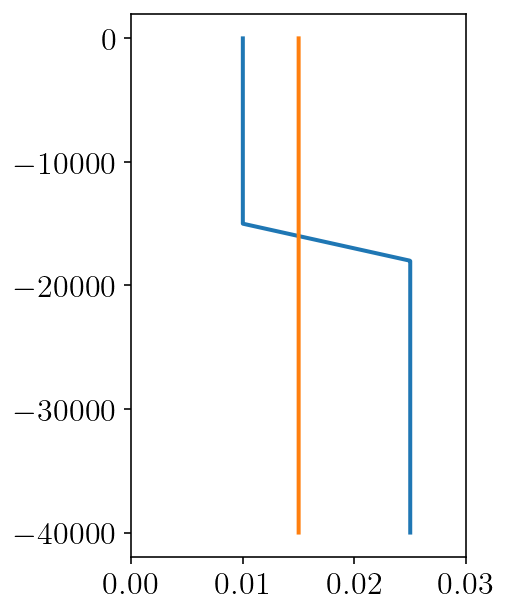

In [161]:
plt.figure(figsize=(3, 5))
plt.plot(fp.a, fy)
plt.plot(np.full(fy.shape[0], fp.b), fy)
plt.xlim([0, 0.03])
plt.show()

In [162]:
mesh_L = np.max(np.abs(np.diff(fault.pts[:,1])))
Lb = shear_modulus * fp.Dc / (sigma_n * fp.b)
hstar = (np.pi * shear_modulus * fp.Dc) / (sigma_n * (fp.b - fp.a))
print(np.min(np.abs(np.diff(fault.pts[:,1]))))
mesh_L, Lb, np.min(hstar[hstar > 0])

5.7623017978912685


(39.135440159836435, 341.3333333333333, 3216.990877275949)

In [163]:
def aging_law(fp, V, state):
    return (fp.b * fp.V0 / fp.Dc) * (np.exp((fp.f0 - state) / fp.b) - (V / fp.V0))

In [164]:
def F(fp, V, state):
    return sigma_n * fp.a * np.arcsinh(V / (2 * fp.V0) * np.exp(state / fp.a))


def dFdV(fp, V, state):
    expsa = np.exp(state / fp.a)
    Q = (V * expsa) / (2 * fp.V0)
    return fp.a * expsa * sigma_n / (2 * fp.V0 * np.sqrt(1 + Q * Q))

In [165]:
def qd_equation(fp, shear_stress, V, state):
    return shear_stress - eta * V - F(fp, V, state)


def qd_equation_dV(fp, V, state):
    return -eta - dFdV(fp, V, state)


def rate_state_solve_old(fp, shear, V_old, state, tol=1e-10, V_min=1e-30):
    def qd(V):
        return qd_equation(fp, shear, V, state)

    def qd_dV(V):
        return qd_equation_dV(fp, V, state)

    V = V_old
    max_iter = 150
    for i in range(max_iter):
        f = qd_equation(fp, shear, V, state)
        dfdv = qd_equation_dV(fp, V, state)
        Vn = np.maximum(V - (f / dfdv), V_min)
        if np.max(np.abs(V - Vn) / np.minimum(Vn, V)) < tol:
            break
        V = Vn
        if i == max_iter - 1:
            raise Exception("Failed to converge.")
    return Vn

In [166]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [167]:
%%cython --verbose
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport asinh, exp, sqrt, fabs, fmax, fmin

def rate_state_solve(
    fp, double sigma_n, double eta, 
    double[::1] shear, double[::1] V_old, double[::1] state, 
    int max_iter=100, double tol=1e-10, double V_min=1e-30
):
    cdef double[::1] fp_a = fp.a
    cdef double fp_b = fp.b
    cdef double fp_V0 = fp.V0
    
    cdef int n = shear.shape[0]
    cdef out_V = np.empty(n, dtype=np.float64)
    cdef double[::1] V = out_V
    
    cdef int i, j
    cdef double F, dFdV, qd_eqtn, Q, qd_eqtn_dV, V_tmp, sigma_F, expsa
    cdef bint failed = False
    
    # We don't parallelize here because the small problems here have more 
    # parallelization overhead than speedup.
    for j in range(n):
        V[j] = V_old[j]
        expsa = exp(state[j] / fp_a[j]) / (2 * fp_V0)
        sigma_F = sigma_n * fp_a[j]
        for i in range(max_iter):
            Q = V[j] * expsa
            F = sigma_F * asinh(Q)
            qd_eqtn = shear[j] - eta * V[j] - F
    
            dFdV = sigma_F * expsa / sqrt(1 + Q * Q)
            qd_eqtn_dV = -eta - dFdV
            
            V_tmp = V[j]
            V[j] = fmax(V[j] - qd_eqtn / qd_eqtn_dV, V_min)
            if fabs(V[j] - V_tmp) / fmin(V[j], V_tmp) < tol:
                break
            if i == max_iter - 1:
                print(V[j], V_tmp)
                failed = True
                
    if failed == 1:
        raise Exception(f"Rate-state Newton failed to converge in {max_iter} iterations.")
    return out_V

In [168]:
shear = np.full(fault.n_pts, 30e6)
V = np.full(fault.n_pts, Vp)
state = np.full(fault.n_pts, 0.7)

def benchmark():
    for i in range(300):
        rate_state_solve(fp, sigma_n, eta, shear, V, state)
        rate_state_solve_old(fp, shear, V, state)

In [169]:
%load_ext line_profiler

%lprun -f benchmark benchmark()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 1.62415 s
File: <ipython-input-168-3e0587f08626>
Function: benchmark at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def benchmark():
     6       301        759.0      2.5      0.0      for i in range(300):
     7       300     267141.0    890.5     16.4          rate_state_solve(fp, sigma_n, eta, shear, V, state)
     8       300    1356246.0   4520.8     83.5          rate_state_solve_old(fp, shear, V, state)

In [170]:
V1 = rate_state_solve(fp, sigma_n, eta, shear, V, state)
V2 = rate_state_solve_old(fp, shear, V, state)

np.any(V1 - V2 > 1e-20)

False

## Quasidynamic earthquake cycle derivatives

In [171]:
from scipy.optimize import fsolve
import copy

fp_amax = copy.deepcopy(fp)
fp_amax.a = amax

init_state_scalar = fsolve(lambda S: aging_law(fp, Vp, S), 0.7)[0]
init_state = np.full(fault.n_pts, init_state_scalar)
tau_amax = F(fp_amax, Vp, init_state_scalar) + eta * Vp
init_traction = np.full(fault.n_pts, tau_amax)

In [172]:
init_slip = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip, init_state))

In [173]:
def calc_system_state(t, y, verbose=False):
    if verbose:
        print(t)
        print(t)
        print(t)
        print(t)
        print(t)

    slip = y[: init_slip.shape[0]]
    state = y[init_slip.shape[0] :]

    if np.any((state < 0) | (state > 1.2)):
        return False

    slip_deficit = t * Vp - slip
    tau_qs = init_traction - total_fault_slip_to_fault_traction.dot(slip_deficit)

    try:
        V = rate_state_solve(fp, sigma_n, eta, tau_qs, calc_system_state.V_old, state)
    except RuntimeError:
        return False
    if not np.all(np.isfinite(V)):
        return False
    calc_system_state.V_old = V

    dstatedt = aging_law(fp, V, state)

    out = slip, slip_deficit, state, tau_qs, V, dstatedt
    if verbose:
        plot_system_state(out)

    return out


calc_system_state.V_old = np.full(fault.n_pts, Vp)


def plot_system_state(SS):
    slip, slip_deficit, state, tau_qs, V, dstatedt = SS

    plt.figure(figsize=(15, 9))
    plt.subplot(2, 3, 1)
    plt.title("slip")
    plt.plot(fault.pts[:, 1], slip)

    plt.subplot(2, 3, 2)
    plt.title("state")
    plt.plot(fault.pts[:, 1], state)

    plt.subplot(2, 3, 3)
    plt.title("tau qs")
    plt.plot(fault.pts[:, 1], tau_qs)

    plt.subplot(2, 3, 4)
    plt.title("slip rate")
    plt.plot(fault.pts[:, 1], V)

    plt.subplot(2, 3, 6)
    plt.title("dstatedt")
    plt.plot(fault.pts[:, 1], dstatedt)
    plt.tight_layout()

    plt.show()


def calc_derivatives(t, y):
    # print('trying', t / siay)
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state = calc_system_state(t, y)  # , verbose=True)
    if not state:
        return np.inf * y
    calc_derivatives.state = state
    derivatives = np.concatenate((state[-2], state[-1]))
    return derivatives

## Integrating through time

In [174]:
from scipy.integrate import RK45

calc_system_state.V_old = np.full(fault.n_pts, Vp)

atol = Vp * 1e-10
rtol = 1e-7
rk23 = RK45(calc_derivatives, 0, init_conditions, 1e50, atol=atol, rtol=rtol)
rk23.h_abs = 60 * 60 * 24

#n_steps = 100000
max_T = 3000 * siay
n_steps = 8000

t_history = [0]
y_history = [init_conditions.copy()]

In [175]:
for i in range(n_steps):
    if rk23.step() != None:
        raise Exception("TIME STEPPING FAILED")
        break

    if i % 1000 == 0:
        print(f'step={i}, time={rk23.t / siay} yrs')
        # plot_system_state(calc_derivatives.state)

    t_history.append(rk23.t)
    y_history.append(rk23.y.copy())

    if rk23.t > max_T:
        break

step=0, time=0.002737907006988508 yrs
step=1000, time=47.35782684018683 yrs
step=2000, time=94.84276147967418 yrs
step=3000, time=142.30598586258284 yrs
step=4000, time=171.43927026994413 yrs
step=5000, time=176.54139407713134 yrs
step=6000, time=223.95760045728656 yrs
step=7000, time=245.5433867408924 yrs


In [176]:
rk23.t / siay

245.54338703015227

In [177]:
y_history = np.array(y_history)
t_history = np.array(t_history)

## Plotting the results

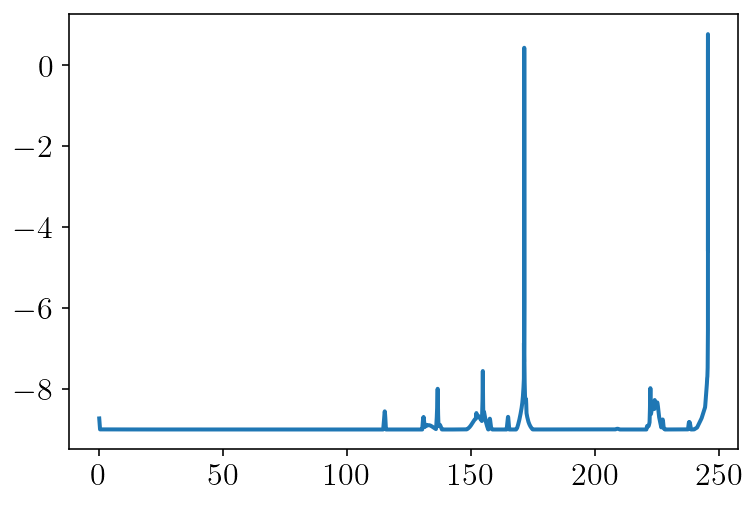

In [178]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.show()

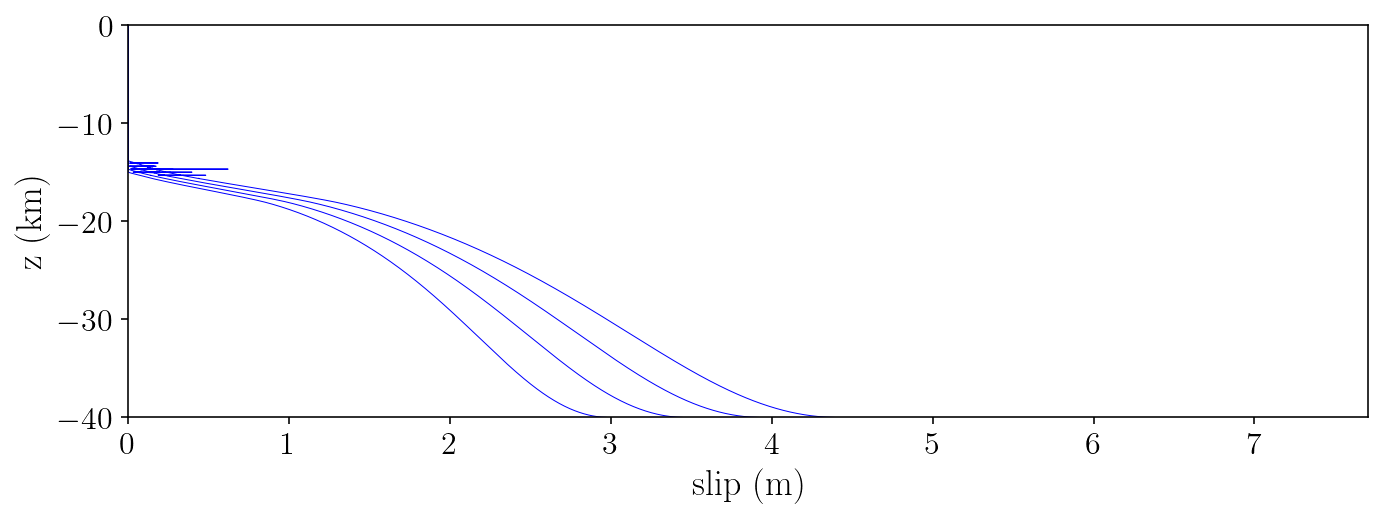

In [191]:
plt.figure(figsize = (10, 4))
last_plt_t = 50
event_times = []
for i in range(2000, 3000):#len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip = y[: init_slip.shape[0]]
    should_plot = False
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"
    if should_plot:
        plt.plot(slip, fy / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

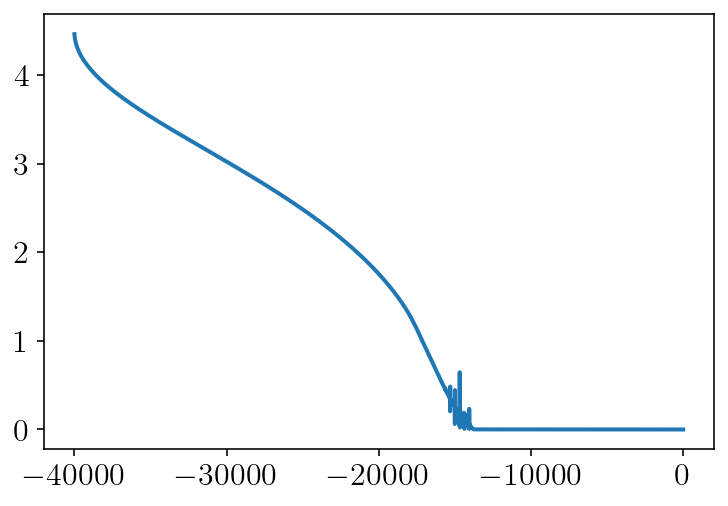

In [194]:
plt.plot(fy, slip)
plt.show()

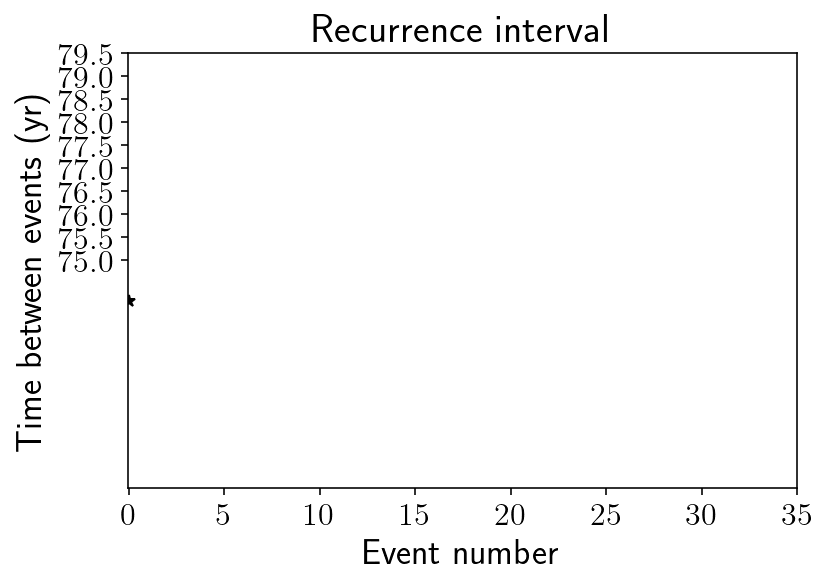

In [180]:
plt.title('Recurrence interval')
plt.plot(np.diff(event_times) / siay, 'k-*')
plt.xticks(np.arange(0, 36, 5))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel('Event number')
plt.ylabel('Time between events (yr)')
plt.show()

In [185]:
t_idx = 0  # np.argmax((t_history > event_times[0] - 10))
fault_idx = np.argmax((-7480 > fy) & (fy > -7500))
n_steps = t_history.shape[0]
t_chunk = t_history[t_idx : (t_idx + n_steps)]
y_chunk = y_history[t_idx : (t_idx + n_steps)]
shear_chunk = []
slip_rate_chunk = []
slip_deficit_chunk = []
for i in range(n_steps):
    system_state = calc_system_state(t_history[t_idx + i], y_history[t_idx + i])
    slip, slip_deficit, state, tau_qs, V, dstatedt = system_state
    slip_deficit_chunk.append(slip_deficit)
    shear_chunk.append((tau_qs - eta * V))
    slip_rate_chunk.append(V)

shear_chunk = np.array(shear_chunk)
slip_rate_chunk = np.array(slip_rate_chunk)
slip_deficit_chunk = np.array(slip_deficit_chunk)

In [186]:
t_start = t_chunk[np.argmax(slip_rate_chunk[:,fault_idx] > 0.1)]

In [188]:
np.max(slip_rate_chunk)

3.726056728414846

In [ ]:
jiang_data = np.loadtxt('jiang.txt')
jiang_vel = np.diff(jiang_data[:,1]) / np.diff(jiang_data[:,0])
jiang_t_start = np.argmax(jiang_vel > 0.1)

In [ ]:
for lims in [(-1, 1), (-15, 30)]:
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(t_chunk - t_start, shear_chunk / 1e6, 'k-o', markersize=0.5, linewidth=0.5)
    plt.plot(jiang_data[:,0] - jiang_data[jiang_t_start,0], jiang_data[:, 3], 'b-*', markersize=0.5, linewidth = 0.5)
    plt.xlim(lims)
    plt.xlabel('Time (s)')
    plt.ylabel('Shear Stress (MPa)')
    #plt.show()

    plt.subplot(2,1,2)
    plt.plot(t_chunk - t_start, slip_rate_chunk, 'k-o', markersize=0.5, linewidth=0.5)
    plt.plot(jiang_data[1:,0] - jiang_data[jiang_t_start,0], jiang_vel[:], 'b-*', markersize=0.5, linewidth = 0.5)
    plt.xlim(lims)
    plt.xlabel('Time (s)')
    plt.ylabel('Slip rate (m/s)')
    plt.tight_layout()
    plt.show()